# Animal Shelter EDA: Classifying the outcome type of animals based on multiple features

### Importing the necessary libraries and data

In [149]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [150]:
data = pd.read_csv('Data/Animal_Shelter_Intake_and_Outcome.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22515 entries, 0 to 22514
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  16683 non-null  object 
 1   Type                  22515 non-null  object 
 2   Breed                 22515 non-null  object 
 3   Color                 22515 non-null  object 
 4   Sex                   22515 non-null  object 
 5   Size                  22482 non-null  object 
 6   Date Of Birth         16978 non-null  object 
 7   Impound Number        22515 non-null  object 
 8   Kennel Number         22498 non-null  object 
 9   Animal ID             22515 non-null  object 
 10  Intake Date           22515 non-null  object 
 11  Outcome Date          22387 non-null  object 
 12  Days in Shelter       22515 non-null  int64  
 13  Intake Type           22515 non-null  object 
 14  Intake Subtype        22515 non-null  object 
 15  Outcome Type       

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,NaN,OTHER,CHICKEN,BROWN,Female,SMALL,NaN,K22-040689,VET,A409950,...,FIELD,NaN,NaN,UNKNOWN,NaN,SANTA ROSA,NaN,NaN,NaN,1
1,NaN,OTHER,GOAT,WHITE,Female,LARGE,NaN,K22-040690,AUC YARD,A409951,...,FIELD,NaN,NaN,HEALTHY,NaN,COUNTY,NaN,NaN,NaN,1
2,REMY,DOG,BEAGLE,BLACK/WHITE,Female,MED,04/11/2014,K21-039564,DS69,A406645,...,PHONE,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95407.0,"95407(38.403734, -122.736775)",1
3,*RONDE,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,07/24/2020,K21-039133,DA30,A406003,...,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA,94954.0,"94954(38.245316, -122.59871)",1
4,*SNOOP,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,08/04/2019,K21-039232,CA02,A406151,...,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1


## 1. Data Clean-Up and Feature Engineering

Here we remove the rows with missing values associated with the outcome. There are some fields in the columns 'Outcome Type, Outcome Subtype, Outcome Condition, Outcome Date' that are empty. We assume that the reason is that an outcome/result has not occurred yet (the animal is still in the shelter).

In [151]:
data = data[~data['Outcome Type'].isnull()]
data = data[~data['Outcome Subtype'].isnull()]
data = data[~data['Outcome Condition'].isnull()]
data = data[~data['Outcome Date'].isnull()]
# Remove the redundant features that won't be useful for predicting the outcome type.
data = data.drop(['Name', 'Outcome Zip Code', 'Location', 'Count', 'Impound Number', 'Animal ID'], axis=1)
data.head()

,Type,Breed,Color,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction
2,DOG,BEAGLE,BLACK/WHITE,Female,MED,04/11/2014,DS69,09/08/2021,09/11/2021,3,STRAY,PHONE,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA
3,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,07/24/2020,DA30,07/24/2021,09/11/2021,49,STRAY,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA
4,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,08/04/2019,CA02,08/04/2021,09/11/2021,38,STRAY,FIELD,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA
5,CAT,SIAMESE,SEAL PT,Spayed,KITTN,10/27/2020,CA03,01/30/2021,02/05/2021,6,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA
6,OTHER,ANGORA-SATIN,TAN/BLACK,Neutered,SMALL,11/29/2019,CA01,09/14/2021,02/12/2022,151,STRAY,OVER THE COUNTER,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,NaN


We consider the age and size of the animal to be an important feature in predicting the outcome type. Therefore, we remove the entries that have a missing value in the 'Date of Birth' and 'Size' columns. We also create 4 new features that indicate the age of an animal (in both months and years) at intake and outcome.

In [152]:
# Remove missing values
data = data[~data['Date Of Birth'].isnull()]
data = data[~data['Size'].isnull()]
# Convert variables to datetime format
data['Date Of Birth'] = pd.to_datetime(data['Date Of Birth'])
data['Intake Date'] = pd.to_datetime(data['Intake Date'])
data['Outcome Date'] = pd.to_datetime(data['Outcome Date'])
# Compute the age in months at intake
data['Age (months) at Intake'] = ((data['Intake Date'] - data['Date Of Birth']) / np.timedelta64(1, 'M')).astype(int)
data['Age (years) at Intake'] = ((data['Intake Date'] - data['Date Of Birth']) / np.timedelta64(1, 'Y')).astype(int)
# Compute the age in months at outcome
data['Age (months) at Outcome'] = ((data['Outcome Date'] - data['Date Of Birth']) / np.timedelta64(1, 'M')).astype(int)
data['Age (years) at Outcome'] = ((data['Outcome Date'] - data['Date Of Birth']) / np.timedelta64(1, 'Y')).astype(int)
data.head()

,Type,Breed,Color,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,Days in Shelter,...,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Age (months) at Intake,Age (years) at Intake,Age (months) at Outcome,Age (years) at Outcome
2,DOG,BEAGLE,BLACK/WHITE,Female,MED,2014-04-11,DS69,2021-09-08,2021-09-11,3,...,RETURN TO OWNER,OVER THE COUNTER_WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,88,7,89,7
3,DOG,CHIHUAHUA SH,TAN,Neutered,SMALL,2020-07-24,DA30,2021-07-24,2021-09-11,49,...,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA,11,0,13,1
4,CAT,DOMESTIC SH,GRAY,Neutered,SMALL,2019-08-04,CA02,2021-08-04,2021-09-11,38,...,ADOPTION,SCAS WEB,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,24,2,25,2
5,CAT,SIAMESE,SEAL PT,Spayed,KITTN,2020-10-27,CA03,2021-01-30,2021-02-05,6,...,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,3,0,3,0
6,OTHER,ANGORA-SATIN,TAN/BLACK,Neutered,SMALL,2019-11-29,CA01,2021-09-14,2022-02-12,151,...,ADOPTION,SCAS WEB,UNKNOWN,PENDING,SANTA ROSA,NaN,21,1,26,2


We also noticed that some animals have multiple colors (e.g., BLACK /WHITE). Therefore, we change the 'Color' column to contain only the primary color of an animal, while creating a new column for the secondary color.

In [153]:
data[['Primary Color', 'Secondary Color']] = data['Color'].str.split('/', expand=True)
data = data.drop(['Color'], axis=1)
data['Secondary Color'] = data['Secondary Color'].fillna('None')
data.head()

,Type,Breed,Sex,Size,Date Of Birth,Kennel Number,Intake Date,Outcome Date,Days in Shelter,Intake Type,...,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Age (months) at Intake,Age (years) at Intake,Age (months) at Outcome,Age (years) at Outcome,Primary Color,Secondary Color
2,DOG,BEAGLE,Female,MED,2014-04-11,DS69,2021-09-08,2021-09-11,3,STRAY,...,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,88,7,89,7,BLACK,WHITE
3,DOG,CHIHUAHUA SH,Neutered,SMALL,2020-07-24,DA30,2021-07-24,2021-09-11,49,STRAY,...,HEALTHY,HEALTHY,SANTA ROSA,*PETALUMA,11,0,13,1,TAN,None
4,CAT,DOMESTIC SH,Neutered,SMALL,2019-08-04,CA02,2021-08-04,2021-09-11,38,STRAY,...,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,24,2,25,2,GRAY,None
5,CAT,SIAMESE,Spayed,KITTN,2020-10-27,CA03,2021-01-30,2021-02-05,6,OWNER SURRENDER,...,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,3,0,3,0,SEAL PT,None
6,OTHER,ANGORA-SATIN,Neutered,SMALL,2019-11-29,CA01,2021-09-14,2022-02-12,151,STRAY,...,UNKNOWN,PENDING,SANTA ROSA,NaN,21,1,26,2,TAN,BLACK


In [154]:
# Map the less popular breeds to other, since there are too many different breeds
mask = data.Breed.map(data.Breed.value_counts()) < 150
data.Breed = data.Breed.mask(mask, 'Other')
# Do the same for primary and secondary colors
mask = data['Primary Color'].map(data['Primary Color'].value_counts()) < 400
data['Primary Color'] = data['Primary Color'].mask(mask, 'Other')
mask = data['Secondary Color'].map(data['Secondary Color'].value_counts()) < 400
data['Secondary Color'] = data['Secondary Color'].mask(mask, 'Other')
# Some outcome types have very few entries so we map those to other as well
mask = data['Outcome Type'].map(data['Outcome Type'].value_counts()) < 50
data['Outcome Type'] = data['Outcome Type'].mask(mask, 'Other')

## 2. Basic Data Analysis

### 2.1 Distribution/Histogram Plot of Ages at Intake and Outcome (in Months and Years)

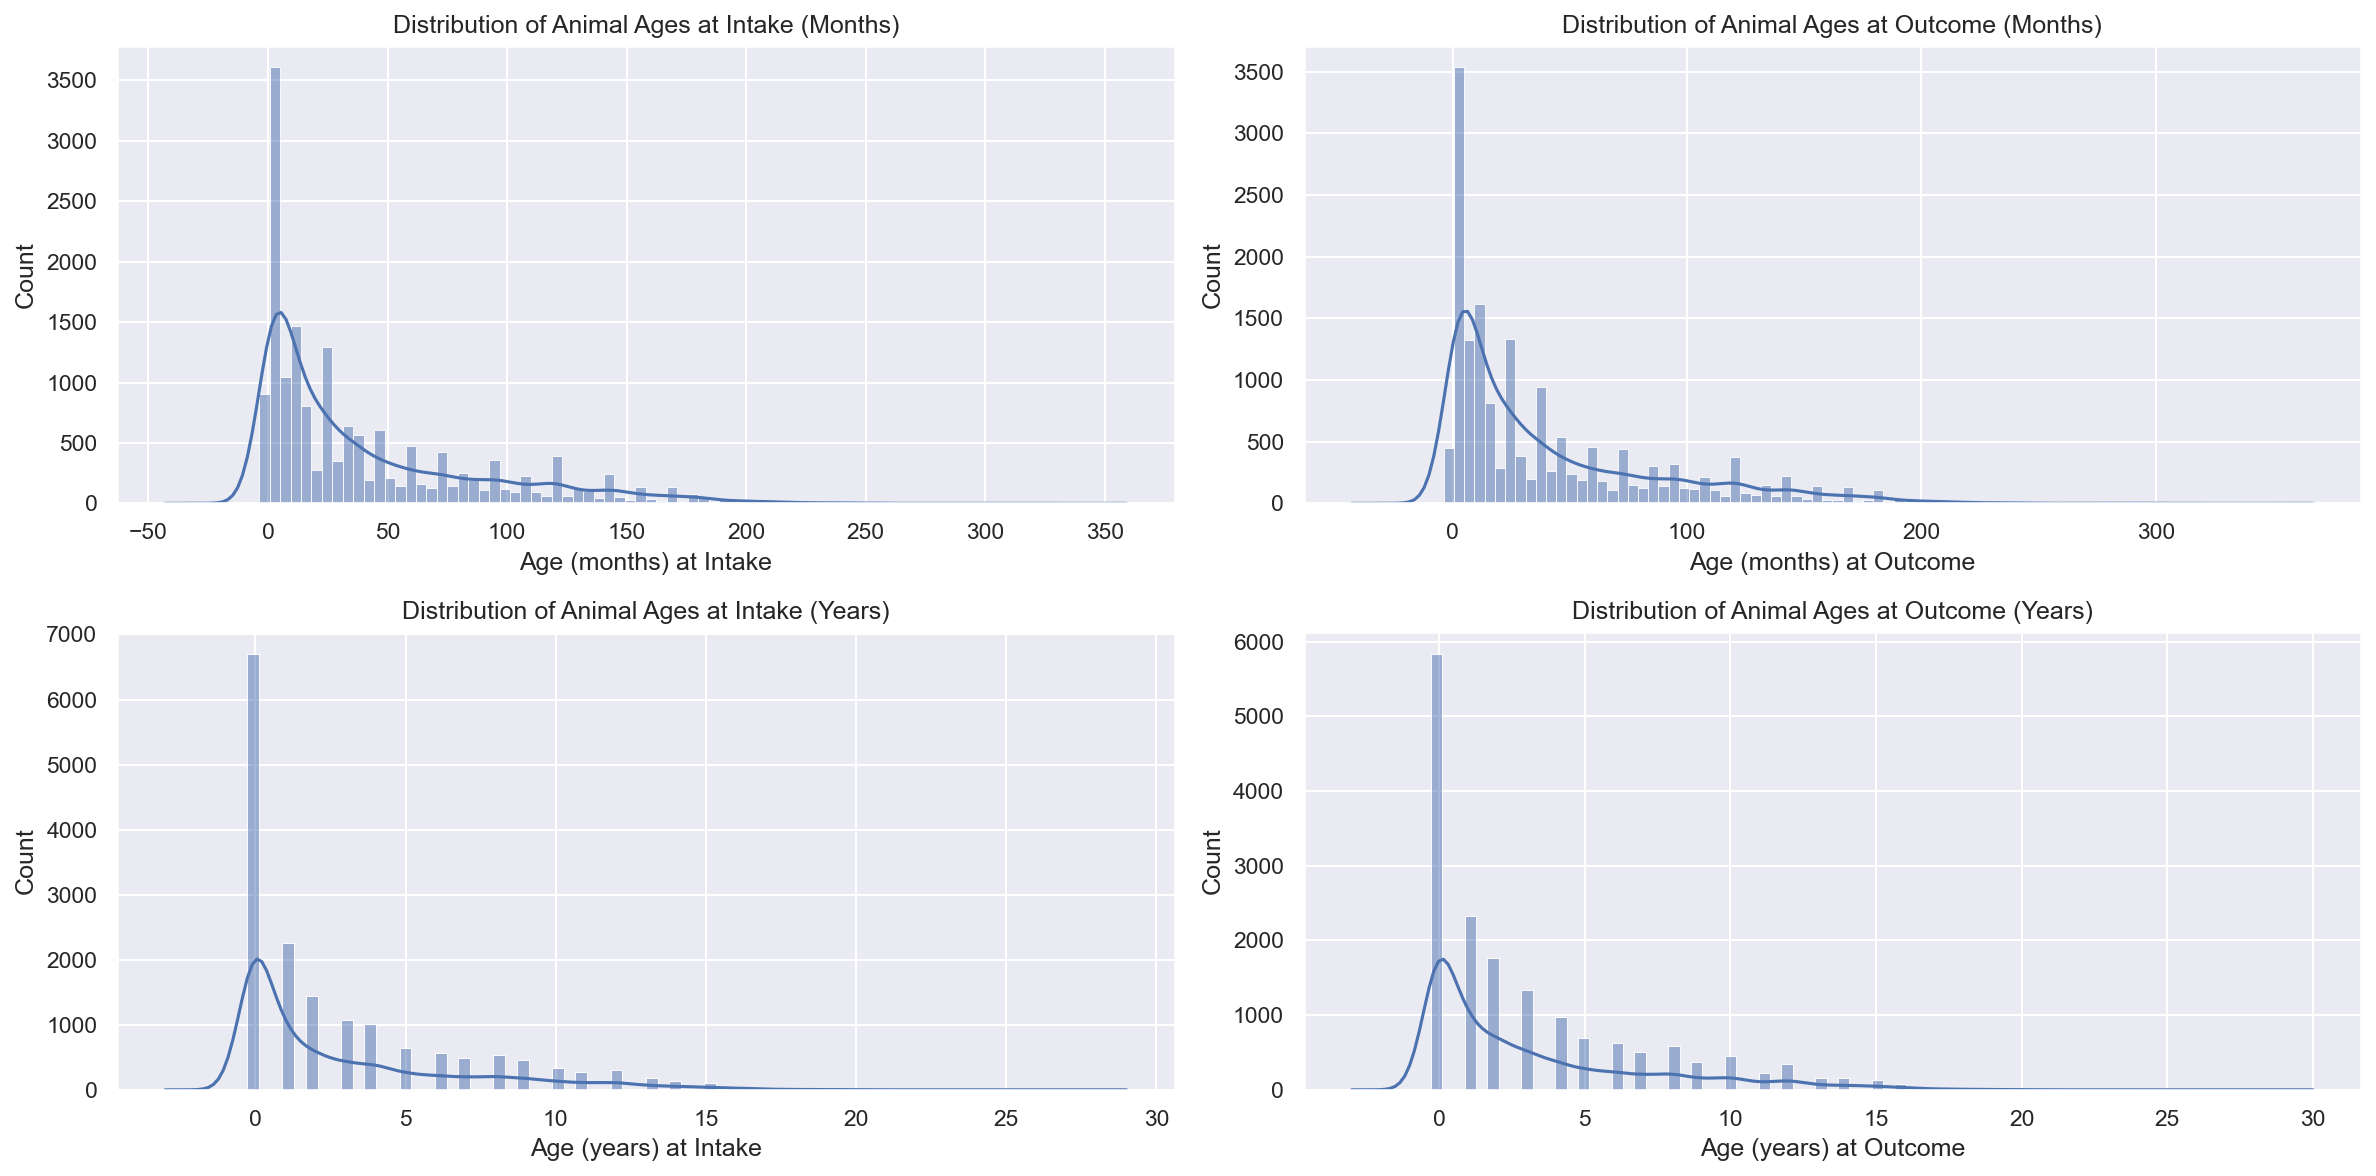

In [155]:
fig, axs = plt.subplots(ncols=2, nrows=2)
# Intake plots
dist_plot = sns.histplot(data=data, x='Age (months) at Intake', kde=True, ax=axs[0][0])
dist_plot.set(title="Distribution of Animal Ages at Intake (Months)")
dist_plot_2 = sns.histplot(data=data, x='Age (years) at Intake', kde=True, ax=axs[1][0])
dist_plot_2.set(title="Distribution of Animal Ages at Intake (Years)")
# Outcome plots
dist_plot_3 = sns.histplot(data=data, x='Age (months) at Outcome', kde=True, ax=axs[0][1])
dist_plot_3.set(title="Distribution of Animal Ages at Outcome (Months)")
dist_plot_4 = sns.histplot(data=data, x='Age (years) at Outcome', kde=True, ax=axs[1][1])
dist_plot_4.set(title="Distribution of Animal Ages at Outcome (Years)")
fig.tight_layout()

Here we can see that the age distributions at intake/outcome are right skewed, meaning that most animals are admitted to the shelter while they are young, and they also leave the shelter (have an outcome) while they are young. The distributions are highly tailed and have many entries that correspond to old animals. We therefore decide to consider animals older than 17 years as outliers and remove them from our dataset.

In [156]:
data = data.loc[data['Age (years) at Intake'] <= 17]

### 2.2 Analysis of Animal Types in the dataset

DOG accounts for 62.41352343139024 % of the dataset
CAT accounts for 34.27179209528966 % of the dataset
OTHER accounts for 3.314684473320099 % of the dataset


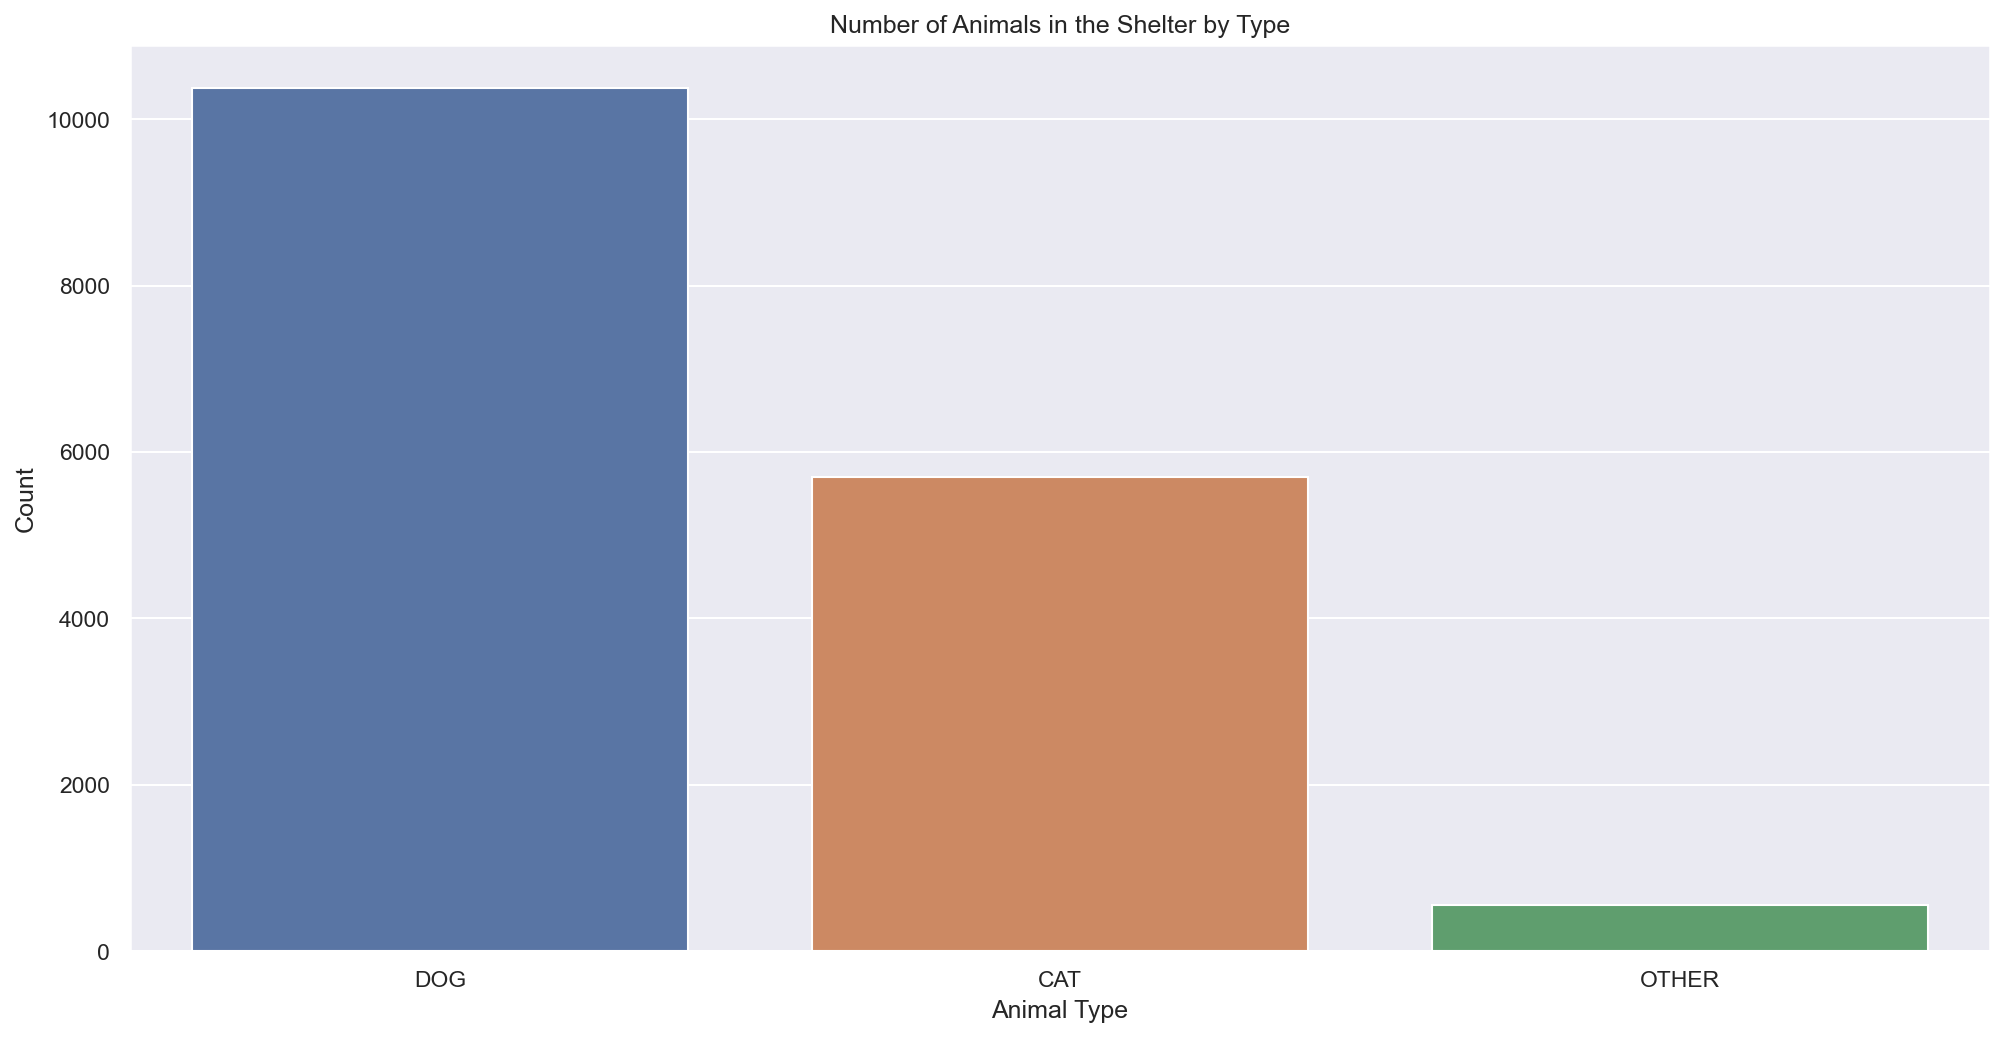

In [157]:
animal_type = data['Type'].value_counts()
animal_type = pd.DataFrame(animal_type)

types_barplot = sns.barplot(data=animal_type, x=animal_type.index, y='Type')
types_barplot.set(title='Number of Animals in the Shelter by Type', xlabel='Animal Type', ylabel='Count')

for index, row in animal_type.iterrows():
    percentage = (row['Type'] / animal_type['Type'].sum()) * 100
    print(index, 'accounts for', percentage, '% of the dataset')

### 2.3 Analysing the factors that might influence the outcome type

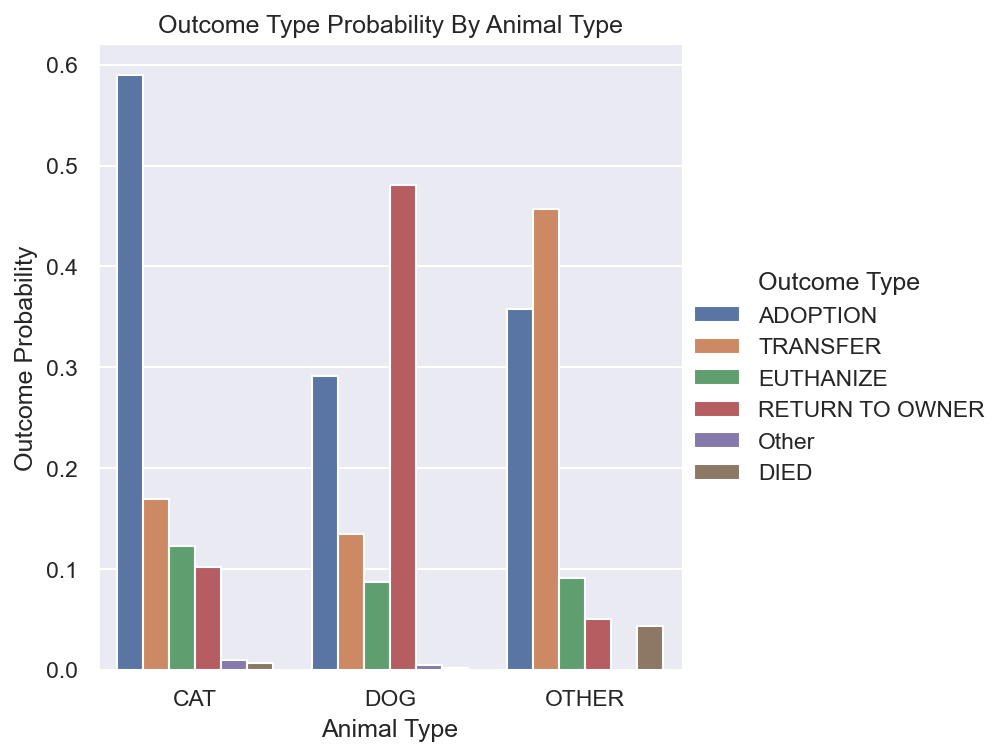

In [168]:
# Create a plot that shows how likely a certain type of animal is going to experience a certain outcome
prob_outcome_type = data.groupby('Type')['Outcome Type'].value_counts(normalize=True).rename('Outcome Probability').reset_index()
type_plot = sns.catplot(data=prob_outcome_type,x= 'Type' ,y='Outcome Probability', hue='Outcome Type',kind='bar')
type_plot.set(title='Outcome Type Probabilities By Animal Type', xlabel='Animal Type')

In the plot above, we can see that cats are much more likely to be adopted than any other species. However, dogs are much more likely to be returned to their owners. For all other animal types have a higher probability of being transferred to a different shelter, suggesting that some breeds may be quite exotic and therefore less likely to have a different outcome.